# SHEVA Shapley values for Earned VAlue management

# Shapley analysis: classification

In [1]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Monte-Carlo simulation dataset
A case study based on Lambrechts (2008)

<img src='https://drive.google.com/uc?id=1-bCEgplDUqbRSO0NW7stGbLa9xI3DX81' width="400" align="left"/>
<img src='https://drive.google.com/uc?id=1JLt90ba0QGqV8yKzDu0-T-yZTB9-u0lW' width="500" align="left"/>

In [2]:
# Simulation  dataset
# Null model (5-rand) of comparison
dfsim_5_rand=pd.read_csv('./data/simulation_EV0.75_5-rand.csv',index_col=0)
dfsim_5_rand['critical_path']=dfsim_5_rand['critical_path'].astype('str')
# Interaction between activities 2-5
dfsim_2_5=pd.read_csv('./data/simulation_EV0.75_2-5.csv',index_col=0)
dfsim_2_5['critical_path']=dfsim_2_5['critical_path'].astype('str')

In [3]:
# Classes 
# Expected time of the project 13
dfsim_2_5['delay']=dfsim_2_5['duration']>13
dfsim_5_rand['delay']=dfsim_5_rand['duration']>13
# Expected time of the project at 75%EV 9.1763
dfsim_2_5['delay@']=dfsim_2_5['duration@']>9.1763
dfsim_5_rand['delay@']=dfsim_5_rand['duration@']>9.1763

In [4]:
print('Null model (5-rand) of comparison')
print(dfsim_5_rand[['duration', 'delay']].groupby(['delay']).count()/dfsim_5_rand.shape[0])
print(dfsim_5_rand[['duration@', 'delay@']].groupby(['delay@']).count()/dfsim_5_rand.shape[0])
print('\nConditional interaction between activities 2-5')
print(dfsim_2_5[['duration', 'delay']].groupby(['delay']).count()/dfsim_2_5.shape[0])
print(dfsim_2_5[['duration@', 'delay@']].groupby(['delay@']).count()/dfsim_2_5.shape[0])

Null model (5-rand) of comparison
       duration
delay          
False   0.20358
True    0.79642
        duration@
delay@           
False     0.51402
True      0.48598

Conditional interaction between activities 2-5
       duration
delay          
False   0.20858
True    0.79142
        duration@
delay@           
False     0.51488
True      0.48512


## Classification

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [6]:
# random seed
seed=1123

### Gradient Boosting Classifier

In [7]:
# Classifier model for dbac analysis (1)
mdc_dbac={'5-rand':GradientBoostingClassifier(max_depth=5, n_estimators=1000,random_state=seed),
     '2-5':GradientBoostingClassifier(max_depth=5, n_estimators=1000,random_state=seed)}

In [22]:
# Estimate the error test
accuracy=dict()
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
    for output in ['delay','delay@']:
        acc=list()
        sfk=StratifiedKFold(n_splits=10)
        y=data.loc[:,output]
        X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
        for train_index, test_index in sfk.split(X,y):
            model=GradientBoostingClassifier(max_depth=5, n_estimators=1000,random_state=seed)
            model.fit(X.loc[train_index,:],y[train_index])
            acc.append(accuracy_score(y[test_index],model.predict(X.loc[test_index,:])))
        accuracy[simulation+'-'+output]=np.mean(acc)
print(accuracy)

{'5-rand-delay': 0.85038, '5-rand-delay@': 0.99268, '2-5-delay': 0.8861000000000001, '2-5-delay@': 0.99238}


{'5-rand-delay': 0.85038, '5-rand-delay@': 0.99268, '2-5-delay': 0.8861000000000001, '2-5-delay@': 0.99238}

In [19]:
# Classifier models for dbac analysis (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # ouput and input variables
  y=data.loc[:,'delay']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdc_dbac[simulation].fit(X,y)
  print('Accuracy(%s): %0.4f' % (simulation,accuracy_score(y,mdc_dbac[simulation].predict(X))))

Accuracy(5-rand): 0.9339
Accuracy(2-5): 0.9518


In [27]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdc_dbac[simulation], open('./data/mdc_dbac_' + simulation + '.pkl', 'wb'))

In [8]:
# Load models
for simulation in ['5-rand','2-5']:
  mdc_dbac[simulation]=pickle.load(open('./data/mdc_dbac_' + simulation + '.pkl', 'rb'))

In [9]:
# Classifier models for tb analysis (1)
mdc_tb={'5-rand':GradientBoostingClassifier(max_depth=5, n_estimators=1000,random_state=seed),
     '2-5':GradientBoostingClassifier(max_depth=5, n_estimators=1000,random_state=seed)}

In [26]:
# Classifier models for tb analysis (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # regression ouput and input variables
  y=data.loc[:,'delay@']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdc_tb[simulation].fit(X,y)
  print('Accuracy(%s): %0.4f' % (simulation,accuracy_score(y,mdc_tb[simulation].predict(X))))

Accuracy(5-rand): 1.0000
Accuracy(2-5): 1.0000


In [29]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdc_tb[simulation], open('./data/mdc_tb_' + simulation + '.pkl', 'wb'))

In [10]:
# Load models
for simulation in ['5-rand','2-5']:
  mdc_tb[simulation]=pickle.load(open('./data/mdc_tb_' + simulation + '.pkl', 'rb'))

## Shapley values for classifier model

In [11]:
#!pip install -q shap

In [12]:
import shap
import matplotlib.pyplot as plt
print('SHAP version:',shap.__version__)

SHAP version: 0.39.0


In [13]:
# Load JS (requiered for showing plots)
shap.initjs()

### Compute Shapley values

In [14]:
# Shapley values - dbac (1)
shap_values_dbac=dict()
explainer_dbac=dict()

In [36]:
# Shapley values - dbac (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_dbac.update({simulation:shap.Explainer(mdc_dbac[simulation])})
  shap_values_dbac.update({simulation:explainer_dbac[simulation](X)})
  shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]


In [37]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_dbac[simulation], open('./data/c_explainer_dbac_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_dbac[simulation], open('./data/c_shap_values_dbac_' + simulation + '.pkl', 'wb'))

In [15]:
# load
for simulation in ['5-rand','2-5']:
  explainer_dbac[simulation]=pickle.load(open('./data/c_explainer_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_dbac[simulation]=pickle.load(open('./data/c_shap_values_dbac_' + simulation + '.pkl', 'rb'))

In [16]:
# Shapley values - tb (1)
shap_values_tb=dict()
explainer_tb=dict()

In [40]:
# Shapley values - tb (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_tb.update({simulation:shap.Explainer(mdc_tb[simulation])})
  shap_values_tb.update({simulation:explainer_tb[simulation](X)})
  shap_values_tb[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [41]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_tb[simulation], open('./data/c_explainer_tb_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_tb[simulation], open('./data/c_shap_values_tb_' + simulation + '.pkl', 'wb'))

In [17]:
# load
for simulation in ['5-rand','2-5']:
  explainer_tb[simulation]=pickle.load(open('./data/c_explainer_tb_' + simulation + '.pkl', 'rb'))
  shap_values_tb[simulation]=pickle.load(open('./data/c_shap_values_tb_' + simulation + '.pkl', 'rb'))

## Backward analysis

In [18]:
study_point = pd.read_csv('./data/study_point.csv',index_col=0)
study_point

,duration1,duration2,duration3,duration4,duration5,duration6,duration7,duration8,duration@1,duration@2,...,duration@4,duration@5,duration@6,duration@7,duration@8,cost@,duration@,cost,duration,critical_path
28656,1.589067,5.167076,7.719155,2.89666,17.757242,3.895929,9.127317,2.517356,1.589067,5.167076,...,2.89666,4.51667,1.964591,5.198019,0.0,20770.922395,9.683746,27702.749577,22.924318,259


In [19]:
# Shaplet values of the study point for all classifier models
study_point_shap_values_dbac=dict()
study_point_explainer_dbac=dict()
study_point_shap_values_tb=dict()
study_point_explainer_tb=dict()

# Shapley values - dbac 
for simulation in ['5-rand','2-5']:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  study_point_explainer_dbac.update({simulation:shap.Explainer(mdc_dbac[simulation])})
  study_point_shap_values_dbac.update({simulation:study_point_explainer_dbac[simulation](X)})
  study_point_shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

# Shapley values - tb 
for simulation in ['5-rand','2-5']:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  study_point_explainer_tb.update({simulation:shap.Explainer(mdc_tb[simulation])})
  study_point_shap_values_tb.update({simulation:study_point_explainer_tb[simulation](X)})
  study_point_shap_values_tb[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [20]:
def watter_plot(type,simulation,n=0):
    if type=='dbac':
        shapval=shap_values_dbac[simulation]
    else: # tb
        shapval=shap_values_tb[simulation]
    
    # Waterfall plot
    #shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
    # There is a bug in the current version with waterfall plot 
    # (see https://github.com/slundberg/shap/issues/1420)
    shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
    shap.plots.waterfall(shap_object,show=False)
    plt.gcf().set_size_inches(10, 5)
    plt.savefig('./figures/waterfall_plot_classification_' +type +'_' +simulation +'.pdf')

### DBAC classification

Null model (5-rand) of comparison


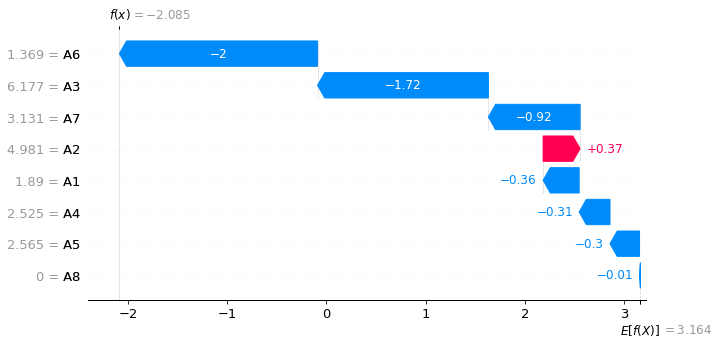

In [21]:
print('Null model (5-rand) of comparison')
watter_plot(type='dbac',simulation='5-rand')

Conditional interaction between activities 2-5


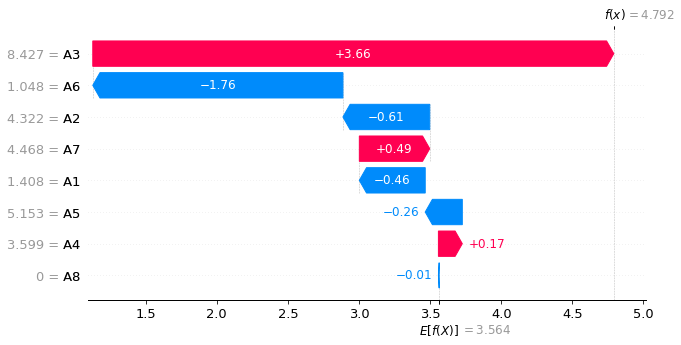

In [22]:
print('Conditional interaction between activities 2-5')
watter_plot(type='dbac',simulation='2-5')

### TB classification

Null model (5-rand) of comparison


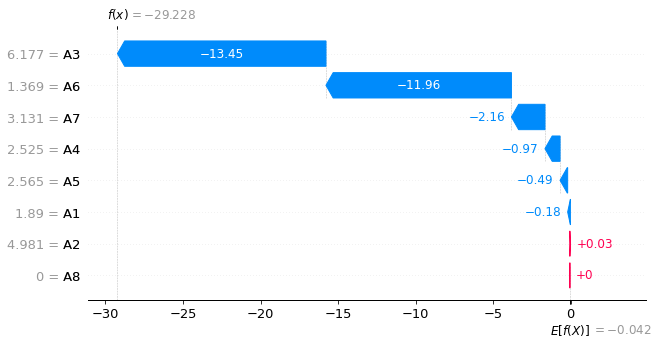

In [23]:
print('Null model (5-rand) of comparison')
watter_plot(type='tb',simulation='5-rand')

Conditional interaction between activities 2-5


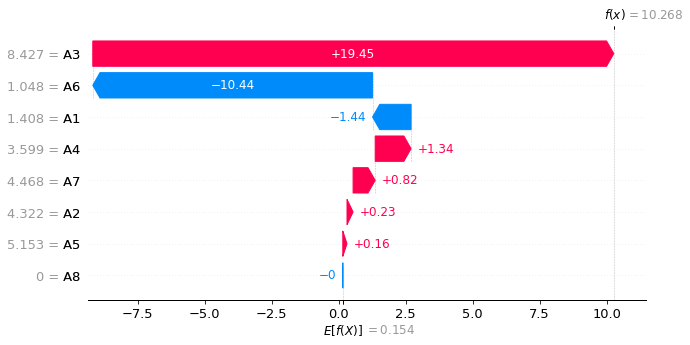

In [24]:
print('Conditional interaction between activities 2-5')
watter_plot(type='tb',simulation='2-5')